In [1]:
import os
import xarray as xr
import matplotlib.pyplot as plt
import numpy as np
import cartopy.crs as ccrs
import cartopy.feature as cfeature
import pandas as pd
import colormaps as cm
import pandas as pd

In [2]:
def plot_map(data_array, projection=ccrs.PlateCarree(), ax=None, add_coastlines=True, 
             add_borders=False, add_gridlines=True, **kwargs):
    """
    Plots geospatial data from an xarray DataArray using Cartopy.

    Args:
        data_array (xr.DataArray): The xarray DataArray containing the geospatial data.
        projection (cartopy.crs.Projection): The map projection to use. Defaults to PlateCarree.
        ax (matplotlib.axes.Axes, optional): Matplotlib axes to plot on. If None, a new figure and axes are created. Defaults to None.
        add_coastlines (bool, optional): Whether to add coastlines. Defaults to True.
        add_borders (bool, optional): Whether to add country borders. Defaults to False.
        add_gridlines (bool, optional): Whether to add gridlines. Defaults to True.
        **kwargs: Additional keyword arguments to pass to xarray.plot.
    """

    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(10, 5), subplot_kw={'projection': projection})
    else:
        fig = ax.get_figure()

    # Use xarray's plotting functionality with Cartopy axes
    data_array.plot(ax=ax, transform=ccrs.PlateCarree(), **kwargs)

    if add_coastlines:
        ax.coastlines()
    if add_borders:
        ax.add_feature(cfeature.BORDERS, linestyle='-')
    if add_gridlines:
        agl = ax.gridlines(draw_labels=True)
        agl.top_labels = False
        agl.right_labels = False
        
    return fig, ax

In [3]:
def get_increments_std_bounds(var, level=0):
    """
    Returns the colorbar bounds for plotting the std of the increments in the given variable.

    Args:
        var (str): variable name
        level (float): vertical level height 

    Returns:
        vmin (float): lower bound of the colorbar
        vmax (float): upper bound of the colorbar 
    """
    if var.lower() == "temp":
        if level > 0:
            vmin = 0.0
            vmax = 0.05
        else: 
            vmin = 0.0
            vmax = 0.3

    elif var.lower() == "so":
        if level > 0:
            vmin = 0.0
            vmax = 0.005
        else: 
            vmin = 0.0
            vmax = 0.1
    else:
        raise NotImplementedError()

    return vmin, vmax

In [4]:
# Open the atm replay zarr-store
atm = xr.open_zarr(
    "gs://noaa-ufs-gefsv13replay/ufs-hr1/0.25-degree-subsampled/03h-freq/zarr/fv3.zarr",
    storage_options={"token": "anon"},
)
atm

<xarray.Dataset> Size: 60TB
Dimensions:        (time: 87020, grid_yt: 192, grid_xt: 384, pfull: 127)
Coordinates:
    cftime         (time) object 696kB dask.array<chunksize=(21755,), meta=np.ndarray>
    ftime          (time) timedelta64[ns] 696kB dask.array<chunksize=(21755,), meta=np.ndarray>
  * grid_xt        (grid_xt) float64 3kB 0.0 0.9375 1.875 ... 357.2 358.1 359.1
  * grid_yt        (grid_yt) float64 2kB 89.82 88.89 87.95 ... -88.18 -89.12
  * pfull          (pfull) float32 508B 0.01278 0.02033 0.03177 ... 996.2 998.8
  * time           (time) datetime64[ns] 696kB 1993-12-31T18:00:00 ... 2023-1...
Data variables: (12/183)
    acond          (time, grid_yt, grid_xt) float32 26GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    albdo_ave      (time, grid_yt, grid_xt) float32 26GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    alnsf          (time, grid_yt, grid_xt) float32 26GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    alnwf          (time, grid_yt, grid_xt) float32 26GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    alvsf          (time, grid_yt, grid_xt) float32 26GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    alvwf          (time, grid_yt, grid_xt) float32 26GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    ...             ...
    xtts           (time, grid_yt, grid_xt) float32 26GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    xu             (time, grid_yt, grid_xt) float32 26GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    xv             (time, grid_yt, grid_xt) float32 26GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    xz             (time, grid_yt, grid_xt) float32 26GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    xzts           (time, grid_yt, grid_xt) float32 26GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    zc             (time, grid_yt, grid_xt) float32 26GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
Attributes:
    abstract:         The NOAA Unified Forecast System (UFS) / Global Ensembl...
    acknowledgement:  To provide appropriate attribution under this license, ...
    description:      This zarr store is a subset of the original GEFSv13 UFS...
    license:          The Global Ensemble Forecast System version 13 (GEFSv13...

In [5]:
# Open the existing ocean zarr-store
ocn = xr.open_zarr(
    "gs://noaa-ufs-gefsv13replay/ufs-hr1/0.25-degree-subsampled/06h-freq/zarr/mom6.zarr",
    storage_options={"token": "anon"},
)
ocn

<xarray.Dataset> Size: 5TB
Dimensions:       (time: 43826, lat: 192, lon: 384, zl: 75, z_l: 75)
Coordinates:
    cftime        (time) object 351kB dask.array<chunksize=(21913,), meta=np.ndarray>
    ftime         (time) timedelta64[ns] 351kB dask.array<chunksize=(21913,), meta=np.ndarray>
  * lat           (lat) float64 2kB 89.82 88.89 87.95 ... -87.25 -88.18 -89.12
  * lon           (lon) float64 3kB 0.0 0.9375 1.875 2.812 ... 357.2 358.1 359.1
  * time          (time) datetime64[ns] 351kB 1993-12-31T18:00:00 ... 2023-12-31
  * z_l           (z_l) float64 600B 0.5154 1.571 2.687 ... 5.698e+03 5.902e+03
  * zl            (zl) float64 600B 1.0 3.0 5.0 ... 3.591e+03 5.111e+03
Data variables: (12/20)
    Heat_PmE      (time, lat, lon) float32 13GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    LW            (time, lat, lon) float32 13GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    LwLatSens     (time, lat, lon) float32 13GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    SSH           (time, lat, lon) float32 13GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    SW            (time, lat, lon) float32 13GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    evap          (time, lat, lon) float32 13GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    ...            ...
    so            (time, z_l, lat, lon) float32 969GB dask.array<chunksize=(1, 75, 192, 384), meta=np.ndarray>
    taux          (time, lat, lon) float32 13GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    tauy          (time, lat, lon) float32 13GB dask.array<chunksize=(1, 192, 384), meta=np.ndarray>
    temp          (time, z_l, lat, lon) float32 969GB dask.array<chunksize=(1, 75, 192, 384), meta=np.ndarray>
    uo            (time, z_l, lat, lon) float32 969GB dask.array<chunksize=(1, 75, 192, 384), meta=np.ndarray>
    vo            (time, z_l, lat, lon) float32 969GB dask.array<chunksize=(1, 75, 192, 384), meta=np.ndarray>
Attributes:
    abstract:         The NOAA Unified Forecast System (UFS) / Global Ensembl...
    acknowledgement:  To provide appropriate attribution under this license, ...
    description:      This zarr store is a subset of the original GEFSv13 UFS...
    license:          The Global Ensemble Forecast System version 13 (GEFSv13...

In [6]:
# ocean statistics -- diffs_stddev_by_level
ocn_diffs_stddev = xr.open_zarr(
    "gcs://noaa-ufs-gefsv13replay/ufs-hr1/0.25-degree-subsampled/06h-freq/zarr/mom6.fvstatistics.l10.1993-2019/diffs_stddev_by_level.zarr",
    storage_options={"token": "anon"},
)
ocn_diffs_stddev

<xarray.Dataset> Size: 500B
Dimensions:  (z_l: 10, z_i: 11)
Coordinates:
  * z_i      (z_i) float64 88B 0.0 1.031 4.498 10.8 ... 114.0 190.2 352.3 483.1
  * z_l      (z_l) float64 80B 0.5154 2.765 7.648 15.95 ... 152.1 271.2 417.7
Data variables:
    LW       float32 4B ...
    SSH      float32 4B ...
    SW       float32 4B ...
    so       (z_l) float64 80B dask.array<chunksize=(1,), meta=np.ndarray>
    temp     (z_l) float64 80B dask.array<chunksize=(1,), meta=np.ndarray>
    uo       (z_l) float64 80B dask.array<chunksize=(1,), meta=np.ndarray>
    vo       (z_l) float64 80B dask.array<chunksize=(1,), meta=np.ndarray>

In [7]:
ocn_diffs_stddev.coords["z_l"].values

array([  0.51540376,   2.76456399,   7.64826769,  15.94596243,
        29.77690983,  55.88826561,  93.66578484, 152.09254646,
       271.22279739, 417.70420074])

## Standard deviation of full states

### at depth

In [8]:
variable = "spfh"
level = 773
nt = 10000

In [9]:
std_var = atm[variable].sel(pfull=level, method='nearest').isel(time=slice(None, nt, 2)).std(dim="time").compute()

/global/homes/n/nagarwal/.conda/envs/graphufs-mpi/lib/python3.11/site-packages/dask/array/numpy_compat.py:56: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/global/homes/n/nagarwal/.conda/envs/graphufs-mpi/lib/python3.11/site-packages/dask/array/numpy_compat.py:56: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)
/global/homes/n/nagarwal/.conda/envs/graphufs-mpi/lib/python3.11/site-packages/dask/array/numpy_compat.py:56: RuntimeWarning: invalid value encountered in divide
  x = np.divide(x1, x2, out)


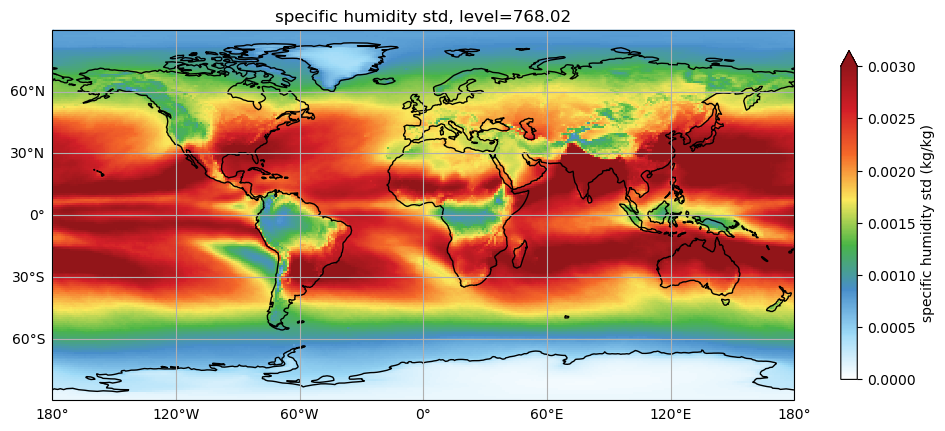

In [10]:
# plot
long_name = atm[variable].attrs["long_name"]
units = atm[variable].attrs["units"]
vmin, vmax = 0, 0.003
kwargs = {"cbar_kwargs":{"orientation": "vertical", "shrink":0.7, "label":f"{long_name} std ({units})", "pad":0.05}, 
          "robust":True, "cmap":cm.WhiteBlueGreenYellowRed, "vmin":vmin, "vmax":vmax,}
title = f"{long_name} std, level={std_var.pfull.values:.2f}"

fig, ax = plot_map(std_var, **kwargs)
ax.set_title(title)
plt.tight_layout()

figname = f"{variable}_std_pfull-{level}_nt-{nt}.png"
plt.savefig(os.path.join(os.getcwd(), "figures", figname), dpi=300)
plt.show()

## Standard deviation of increments

### surface

In [11]:
variable = "so"

In [12]:
# standard deviation of increments: surface
increments_std_sfc = ocn[variable].isel(z_l=0).diff(dim="time").std(dim="time").compute()

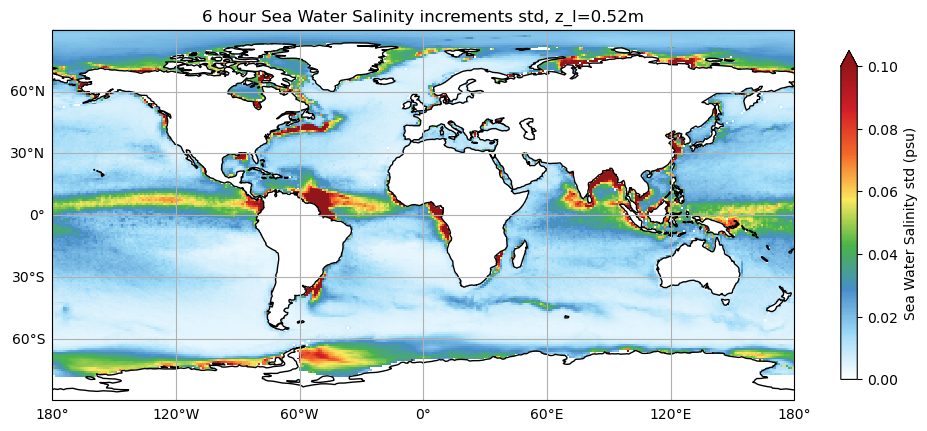

In [13]:
# plot
long_name = ocn[variable].attrs["long_name"]
units = ocn[variable].attrs["units"]
vmin, vmax = get_increments_std_bounds(variable)
kwargs = {"cbar_kwargs":{"orientation": "vertical", "shrink":0.7, "label":f"{long_name} std ({units})", "pad":0.05}, 
          "robust":True, "cmap":cm.WhiteBlueGreenYellowRed, "vmin":vmin, "vmax":vmax,}
title = f"6 hour {long_name} increments std, z_l={increments_std_sfc.z_l.values:.2f}m"

fig, ax = plot_map(increments_std_sfc, **kwargs)
ax.set_title(title)
plt.tight_layout()

figname = f"{variable}_6hours_increments_std_surface.png"
#plt.savefig(os.path.join(os.getcwd(), "figures", figname), dpi=300)
plt.show()

In [14]:
# mean std across the globe
increments_std_sfc.mean().values

array(0.02182938)

### at depth

In [15]:
z_l = 420 # location of the cell center in FV regridded ocean data

In [16]:
# standard deviation of increments at z_l
increments_std_z_l = ocn[variable].sel(z_l=z_l, method='nearest').isel(time=slice(None, 5000)).diff(dim="time").std(dim="time").compute()

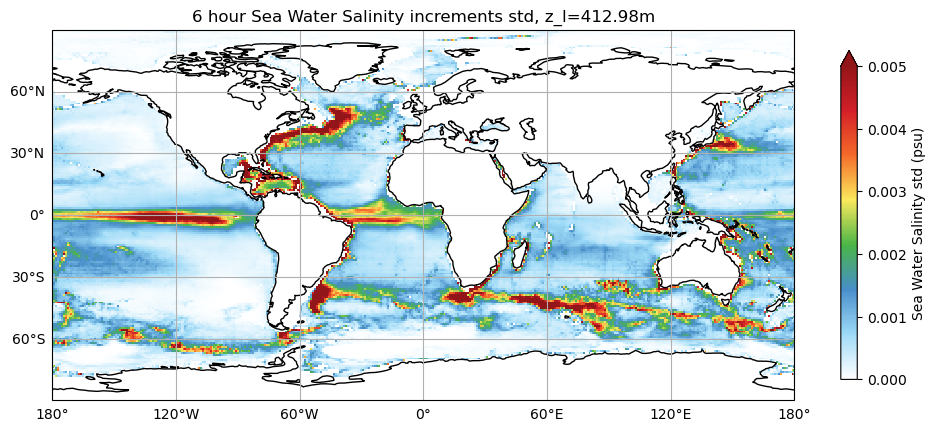

In [17]:
# plot
vmin, vmax = get_increments_std_bounds(variable, z_l)
kwargs = {"cbar_kwargs":{"orientation": "vertical", "shrink":0.7, "label":f"{long_name} std ({units})", "pad":0.05}, 
          "robust":True, "cmap":cm.WhiteBlueGreenYellowRed, "vmin":vmin, "vmax":vmax,}
title = f"6 hour {long_name} increments std, z_l={increments_std_z_l.z_l.values:.2f}m"

fig, ax = plot_map(increments_std_z_l, **kwargs)
ax.set_title(title)
plt.tight_layout()

figname = f"{variable}_6hours_increments_std_z_l-{int(np.round(increments_std_z_l.z_l.values))}m.png"
#plt.savefig(os.path.join(os.getcwd(), "figures", figname), dpi=300)
plt.show()

In [18]:
# get the mean variability
increments_std_z_l.mean().values

array(0.00095728)

In [19]:
## ratio of variability at surface vs at z_l depth
ratio = increments_std_sfc.mean().values/increments_std_z_l.mean().values
print("ratio = ",ratio)

ratio =  22.803640669772815


## std thresholding

## surface

In [20]:
# define the threshold 
std_threshold_sfc = 0.06

In [21]:
# get the mask and masked std
mask  = xr.where(increments_std_sfc>std_threshold_sfc, 1, 0)
increments_std_sfc_masked = increments_std_sfc.where(mask)

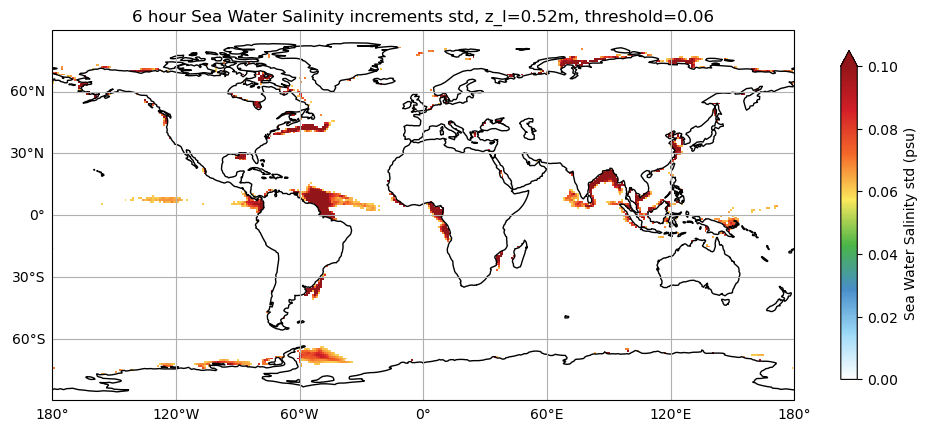

In [22]:
# plot
long_name = ocn[variable].attrs["long_name"]
units = ocn[variable].attrs["units"]
vmin, vmax = get_increments_std_bounds(variable)
kwargs = {"cbar_kwargs":{"orientation": "vertical", "shrink":0.7, "label":f"{long_name} std ({units})", "pad":0.05}, 
          "robust":True, "cmap":cm.WhiteBlueGreenYellowRed, "vmin":vmin, "vmax":vmax,}
title = f"6 hour {long_name} increments std, z_l={increments_std_sfc.z_l.values:.2f}m, threshold={std_threshold_sfc}"

fig, ax = plot_map(increments_std_sfc_masked, **kwargs)
ax.set_title(title)
plt.tight_layout()

#figname = f"{variable}_6hours_increments_std_surface.png"
#plt.savefig(os.path.join(os.getcwd(), "figures", figname), dpi=300)
plt.show()

In [23]:
# get the mean std after thresholding
increments_std_sfc_masked.mean().values

array(0.11252148)

In [24]:
# ratio
ratio_threshold_vs_orig = increments_std_sfc_masked.mean().values/increments_std_sfc.mean().values
print("ratio of thresholded std mean vs the original:", ratio_threshold_vs_orig)

ratio of thresholded std mean vs the original: 5.154590058310225


### at depth

In [25]:
std_threshold_z_l = 0.003

In [26]:
# get the mask and masked std
mask  = xr.where(increments_std_z_l>std_threshold_z_l, 1, 0)
increments_std_z_l_masked = increments_std_z_l.where(mask)

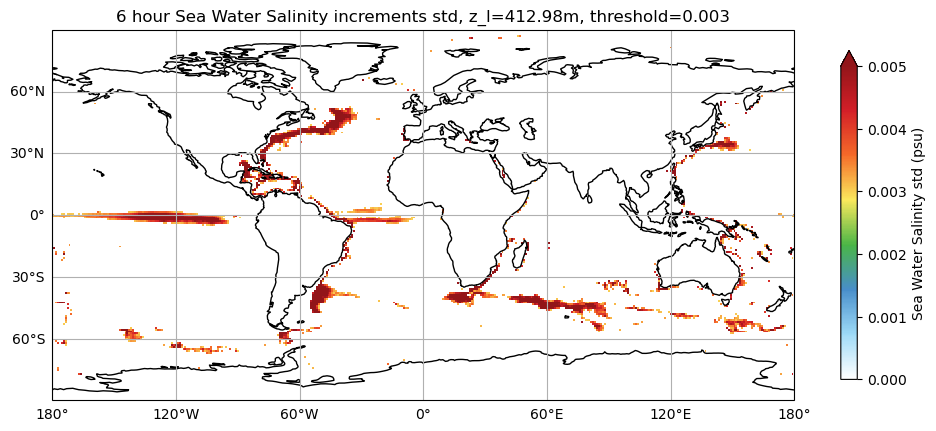

In [27]:
# plot
vmin, vmax = get_increments_std_bounds(variable, z_l)
kwargs = {"cbar_kwargs":{"orientation": "vertical", "shrink":0.7, "label":f"{long_name} std ({units})", "pad":0.05}, 
          "robust":True, "cmap":cm.WhiteBlueGreenYellowRed, "vmin":vmin, "vmax":vmax,}
title = f"6 hour {long_name} increments std, z_l={increments_std_z_l.z_l.values:.2f}m, threshold={std_threshold_z_l}"

fig, ax = plot_map(increments_std_z_l_masked, **kwargs)
ax.set_title(title)
plt.tight_layout()

#figname = f"{variable}_6hours_increments_std_z_l={int(np.round(increments_std_z_l.z_l.values))}m.png"
#plt.savefig(os.path.join(os.getcwd(), "figures", figname), dpi=300)
plt.show()

In [28]:
# get the mean std after thresholding
increments_std_z_l_masked.mean().values

array(0.00507755)

In [29]:
# ratio
ratio_threshold_vs_orig_z_l = increments_std_z_l_masked.mean().values/increments_std_z_l.mean().values
print("ratio of thresholded std mean vs the original:", ratio_threshold_vs_orig_z_l)

ratio of thresholded std mean vs the original: 5.304169221765337


In [30]:
## ratio of variability at surface vs at z_l depth
ratio = increments_std_sfc_masked.mean().values/increments_std_z_l_masked.mean().values
print("ratio = ",ratio)

ratio =  22.16057116114572


In [31]:
# maximum standard deviation of diffs for all levels
increments_std_z_l_all = ocn[variable].sel(z_l=ocn_diffs_stddev.coords["z_l"].values, method='nearest').isel(time=slice(None, 10000)).diff(dim="time").std(dim="time").compute()
increments_std_max_z_l_all = increments_std_z_l_all.max(dim=("lat","lon"))

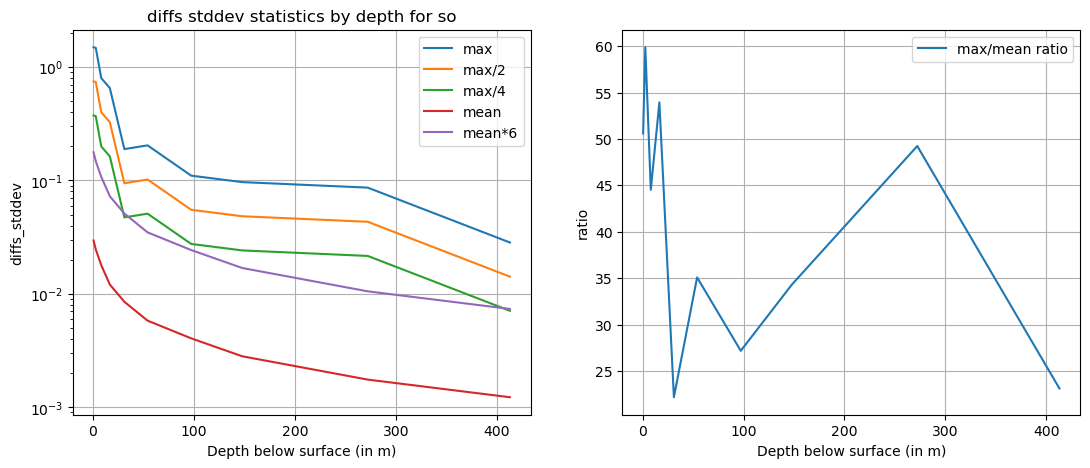

In [32]:
## diffs_stddev plot for different scenarios
fig, ax = plt.subplots(1, 2, figsize=(13,5))

ax[0].semilogy(increments_std_max_z_l_all.coords["z_l"].values, increments_std_max_z_l_all.values, label="max")
ax[0].semilogy(increments_std_max_z_l_all.coords["z_l"].values, increments_std_max_z_l_all.values/2, label="max/2")
ax[0].semilogy(increments_std_max_z_l_all.coords["z_l"].values, increments_std_max_z_l_all.values/4, label="max/4")
ax[0].semilogy(increments_std_max_z_l_all.coords["z_l"].values, ocn_diffs_stddev.so.values, label="mean")
ax[0].semilogy(increments_std_max_z_l_all.coords["z_l"].values, 6*ocn_diffs_stddev.so.values, label="mean*6")
ax[0].set_xlabel("Depth below surface (in m)")
ax[0].set_ylabel("diffs_stddev")
ax[0].set_title(f"diffs stddev statistics by depth for {variable}")
ax[0].legend()
ax[0].grid()

ax[1].plot(increments_std_max_z_l_all.coords["z_l"].values, increments_std_max_z_l_all.values/ocn_diffs_stddev.so.values, label="max/mean ratio")
ax[1].set_xlabel("Depth below surface (in m)")
ax[1].set_ylabel("ratio")
ax[1].legend()
plt.grid()

figname = f"diffs_stddev_{variable}_max_mean_and_ratio.png" 
plt.savefig(os.path.join("figures", figname), dpi=300)
plt.show()

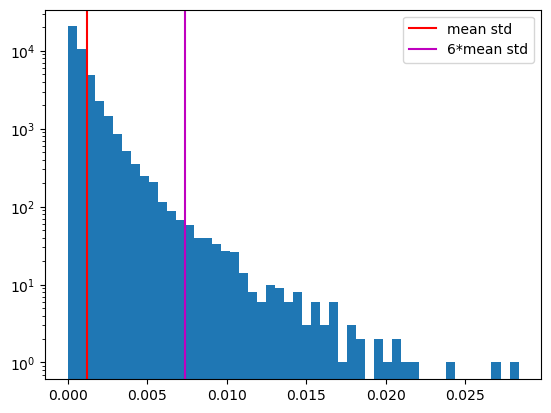

In [84]:
iz_l = -1
plt.hist(increments_std_z_l_all.isel(z_l=iz_l).values.flatten(), 50, log=True)
plt.axvline(ocn_diffs_stddev.so.isel(z_l=iz_l).values, color="r", label="mean std")
plt.axvline(6*ocn_diffs_stddev.so.isel(z_l=iz_l).values, color="m", label="6*mean std")
plt.legend()
plt.show()